# Tesla Stock Price Time Series Prediction

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import date
#loading important libraries
import numpy as np 
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pandas as pd
data = pd.read_csv("../input/tesla-data/TSLA.csv")


data.shape
from statsmodels.graphics import tsaplots
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error


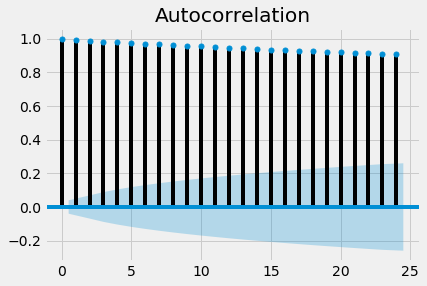

In [2]:

#preprocessing

fig = tsaplots.plot_acf(data["Close"], lags=24)

# Show plot
plt.show()







Visually see if the data is stationary


 The idea beneath seasonal decomposition is to state that any series can be decomposed in a sum (or a product) of 3 components: a trend, a seasonal component, and residuals.

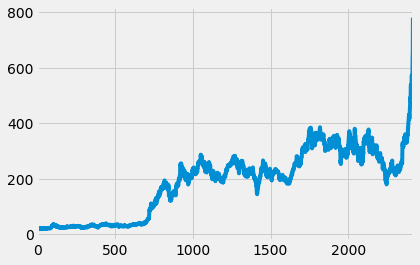

In [3]:
data["Close"].plot()

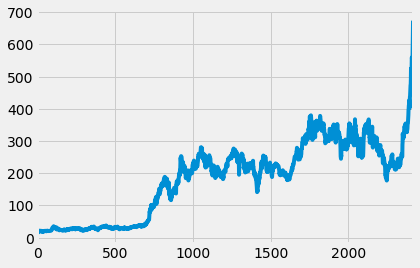

In [4]:
data["Low"].plot()

Although its very clear that we have a trend (varying mean) in the above series, this visual approach might not always give accurate results. It is better to confirm the observations using some statistical test

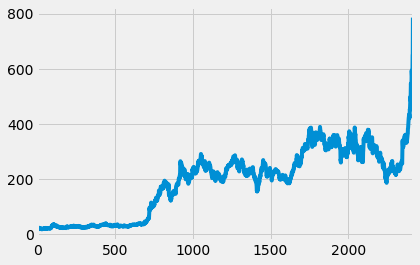

In [5]:
data["High"].plot()

In [6]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(data["Close"])


Results of Dickey-Fuller Test:
Test Statistic                    1.400069
p-value                           0.997114
#Lags Used                       18.000000
Number of Observations Used    2397.000000
Critical Value (1%)              -3.433081
Critical Value (5%)              -2.862747
Critical Value (10%)             -2.567412
dtype: float64


If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary).

4. Making a Time Series Stationary

Now that we are familiar with the concept of stationarity and its different types, we can finally move on to actually making our series stationary. Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first.

 

Differencing

In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:



Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. Let’s do a quick log transform and differencing on our air passenger dataset:

Transformation


In [7]:
data["Close_log"] = np.log(data["Close"])
data["Close_log"] = data["Close_log"] - data["Close_log"].shift(1)
data = data[["Date","Close_log"]].set_index('Date')


In [8]:
data.head()


,Close_log
Date,
2010-06-29,NaN
2010-06-30,-0.002515
2010-07-01,-0.081723
2010-07-02,-0.134312
2010-07-06,-0.175470


In [9]:
train = data.Close_log[1:1812]
test = data.Close_log[1812:2416]




Holt-Winter’s model has several parts : a level, a trend, and in the case of a seasonal smoothing, a seasonal component. 

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [10]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

                             ARIMA Model Results                              
Dep. Variable:            D.Close_log   No. Observations:                 1810
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3507.392
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sun, 16 Feb 2020   AIC                          -7000.784
Time:                        19:42:18   BIC                          -6962.276
Sample:                             1   HQIC                         -6986.573
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.845e-05      0.000      0.162      0.871      -0.000       0.001
ar.L1.D.Close_log    -0.8068      0.023    -34.622      0.000      -0.852      -0.761
ar.L2.D.Close_log    -0.

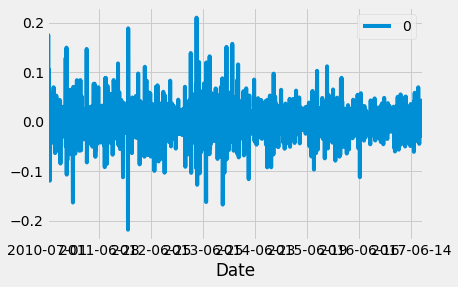

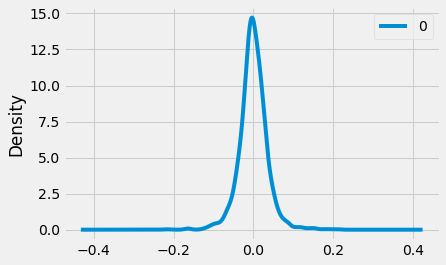

                 0
count  1810.000000
mean     -0.000070
std       0.034902
min      -0.218084
25%      -0.017828
50%      -0.001273
75%       0.018148
max       0.210245


In [11]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information captured by the model.
Next, we get a density plot of the residual error values, suggesting the errors are Gaussian and is centered on zero.

In [12]:
test.head()

Date
2017-09-08   -0.020779
2017-09-11    0.057406
2017-09-12   -0.002588
2017-09-13    0.009548
2017-09-14    0.030680
Name: Close_log, dtype: float64

In [13]:


# Forecast
fc, se, conf = model_fit.forecast(604, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)



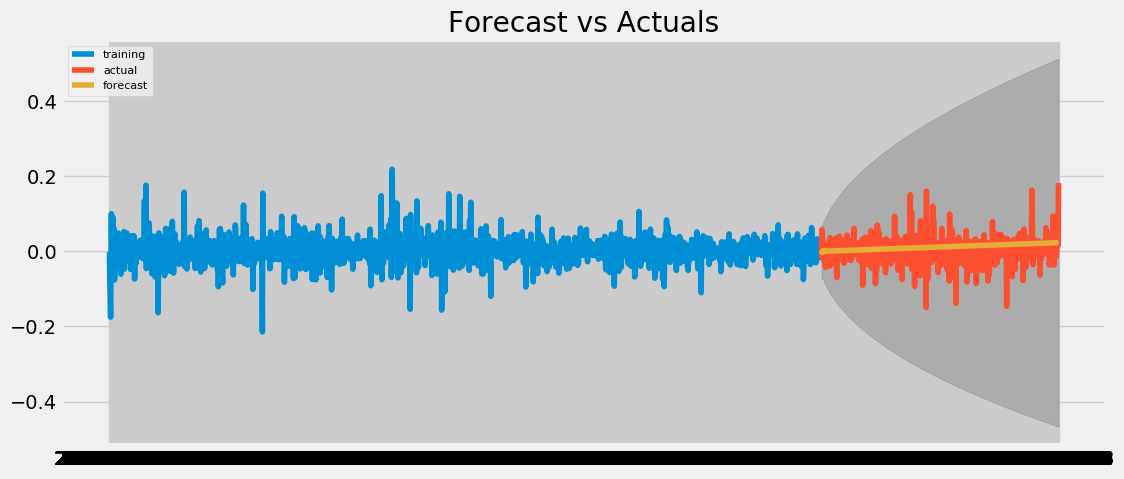

In [14]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [15]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
   
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': inf,
 'me': 0.00999790160103204,
 'mae': 0.025010936088970006,
 'mpe': inf,
 'rmse': 0.035019119226885304}